In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
# demand_bookings_df = pd.read_csv('./hotel_bookings.csv')
# demand_bookings_df.rename(columns = {
#     'adults': 'no_of_adults',
#     'children': 'no_of_children',
#     'stays_in_weekend_nights': 'no_of_weekend_nights',
#     'stays_in_week_nights': 'no_of_week_nights',
#     'meal': 'type_of_meal_plan',
#     'required_car_parking_spaces': 'required_car_parking_space',
#     'reserved_room_type': 'room_type_reserved',
#     'lead_time': 'lead_time',
#     'arrival_date_year': 'arrival_year',
#     'arrival_date_month': 'arrival_month',
#     'arrival_date_day_of_month': 'arrival_date',
#     'market_segment': 'market_segment_type',
#     'is_repeated_guest': 'repeated_guest',
#     'previous_cancellations': 'no_of_previous_cancellations',
#     'previous_bookings_not_canceled': 'no_of_previous_bookings_not_canceled',
#     'adr': 'avg_price_per_room',
#     'total_of_special_requests': 'no_of_special_requests',
#     'is_canceled': 'booking_status'
# }, inplace=True)

# demand_bookings_df['arrival_month'] = demand_bookings_df['arrival_month'].map({
#     'January': 1, 'February': 2, 'March': 3, 'April': 4,
#     'May': 5, 'June': 6, 'July': 7, 'August': 8,
#     'September': 9, 'October': 10, 'November': 11, 'December': 12
# })

# demand_bookings_df['type_of_meal_plan'] = \
#     demand_bookings_df['type_of_meal_plan'].map({
#         'BB': 0, 'HB': 2, 'SC': 1, 'Undefined': 1, 'FB': 3
#     })

# demand_bookings_df['market_segment_type'] = \
#     demand_bookings_df['market_segment_type'].map({
#         "'Online TA": 1, "Offline TA/TO": 0, "Corporate": 2, "Complementary": 4, "Aviation": 3
#     })

# demand_bookings_df['room_type_reserved'] = \
#     demand_bookings_df['room_type_reserved'].map({
#         'A':  0, 'D':  1, 'E':  3, 'F':  2, 'G':  4, 'B':  5, 'C':  6
#     })

# demand_bookings_df['market_segment_type'].fillna(5, inplace=True)
# demand_bookings_df['room_type_reserved'].fillna(7, inplace=True)

In [3]:
train = pd.read_csv('./train.csv').drop('id',axis=1)
origin = pd.read_csv('./archive/train__dataset.csv')
train = pd.concat([train,origin],axis=0).drop_duplicates().reset_index(drop=True) # demand_bookings_df
test = pd.read_csv('./test.csv').drop('id',axis=1)

In [4]:
train.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [5]:
train[(train['lead_time'] < 10) & (train['avg_price_per_room'] < 13)]['booking_status'].value_counts()

0    604
1     15
Name: booking_status, dtype: int64

In [6]:
train = train[(train.lead_time > 0) | ((train.lead_time == 0) & (train.booking_status == 0))]
train = train[train.no_of_adults != 0] # 성인이 없는 경우
# train = train[train.no_of_children < 5] # 해당경우 아이의수를 5로 수정
train = train[train.no_of_weekend_nights < 7]
# train = train[train.avg_price_per_room < 5]
# 주말수와 주중수가 말이 안되는경우 색출
# 충성고객 레이블

6


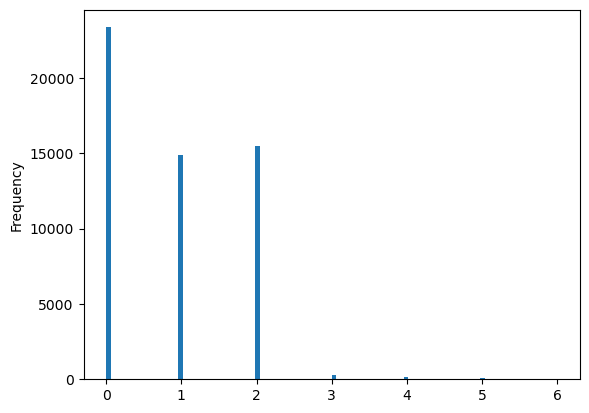

In [7]:
train.no_of_weekend_nights.plot.hist(bins=100)
print(train.no_of_weekend_nights.max())

17


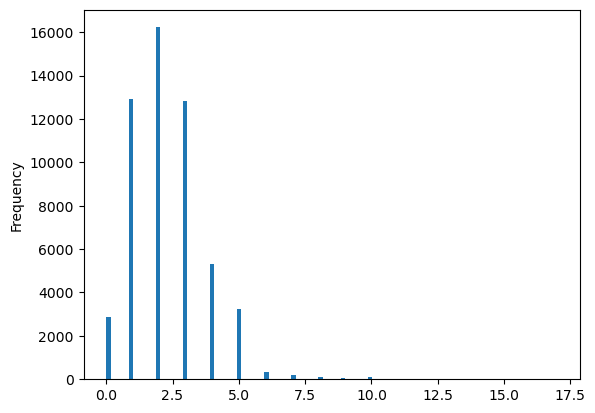

In [8]:
train.no_of_week_nights.plot.hist(bins=100)
print(train.no_of_week_nights.max())

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data = np.array(train['avg_price_per_room']).reshape(-1,1)
# scaler.fit(data)
# data = scaler.transform(data)
# train['avg_price_per_room'] = data

# data = np.array(train['lead_time']).reshape(-1,1)
# scaler.fit(data)
# data = scaler.transform(data)
# train['lead_time'] = data

In [10]:
# train['instance'] = (train['lead_time']+train['avg_price_per_room'])**1/2
# test['instance'] = (test['lead_time']+test['avg_price_per_room'])**1/2

In [11]:
# train[train['instance'] < 0.1]['booking_status'].value_counts()

In [12]:
# tp = []
# for i in train['instance']:
#     if i < 0.1:
#         tp.append(1)
#     else:
#         tp.append(0)
# train['instance'] = tp

# tp = []
# for i in test['instance']:
#     if i < 0.1:
#         tp.append(1)
#     else:
#         tp.append(0)
# test['instance'] = tp

C:\Users\user\AppData\Local\Temp\ipykernel_24760\3765977564.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((train[train['booking_status'] == 0]['lead_time']+train[train['booking_status'] == 0]['avg_price_per_room']), label = 'Normal', color = 'b', bins = 100)
C:\Users\user\AppData\Local\Temp\ipykernel_24760\3765977564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see


<AxesSubplot: ylabel='Density'>

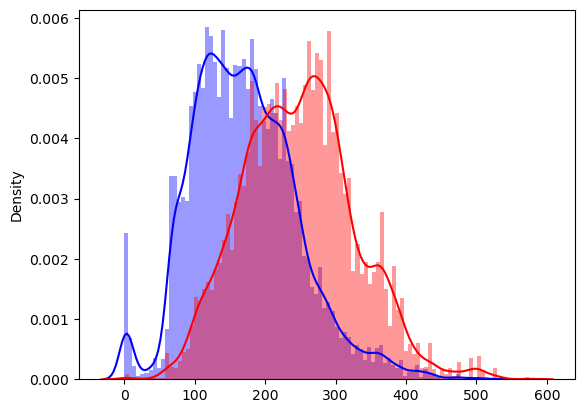

In [13]:
import seaborn as sns
sns.distplot((train[train['booking_status'] == 0]['lead_time']+train[train['booking_status'] == 0]['avg_price_per_room']), label = 'Normal', color = 'b', bins = 100)
sns.distplot((train[train['booking_status'] == 1]['lead_time']+train[train['booking_status'] == 1]['avg_price_per_room']), label = 'Normal', color = 'r', bins = 100)

---

In [14]:
train[train.booking_status == 0]['no_of_previous_cancellations'].value_counts()

0     34011
1       237
2        75
3        72
11       35
4        21
5         6
6         3
13        2
8         1
Name: no_of_previous_cancellations, dtype: int64

In [15]:
train[train.booking_status == 1]['no_of_previous_bookings_not_canceled'].value_counts()

0     19784
1         4
4         1
12        1
Name: no_of_previous_bookings_not_canceled, dtype: int64

In [16]:
train[train.booking_status == 1]['repeated_guest'].value_counts()

0    19776
1       14
Name: repeated_guest, dtype: int64

In [17]:
train[train.booking_status == 1].no_of_special_requests.value_counts()

0    13824
1     4594
2     1367
3        5
Name: no_of_special_requests, dtype: int64

---

In [18]:
train[train.avg_price_per_room > 150].booking_status.value_counts()

0    3725
1    2335
Name: booking_status, dtype: int64

In [19]:
tp1 = []
for i in train.avg_price_per_room:
    if i < 10:
        tp1.append(0)
    elif i >= 10 and i < 100:
        tp1.append(1)
    else:
        tp1.append(2)
train['expensive'] = tp1

tp2 = []
for i in test.avg_price_per_room:
    if i < 10:
        tp2.append(0)
    elif i >= 10 and i < 100:
        tp2.append(1)
    else:
        tp2.append(2)
test['expensive'] = tp2

In [20]:
cols = train.columns
train = train.loc[:,cols]
train['guest'] = train['no_of_adults'] + train['no_of_children']
test['guest'] = test['no_of_adults'] + test['no_of_children']

In [21]:
drop_target = ['arrival_year','arrival_date','no_of_children'
              ]
train = train.drop(drop_target,axis=1)
test = test.drop(drop_target,axis=1)

In [22]:
train.booking_status.value_counts()

0    34463
1    19790
Name: booking_status, dtype: int64

In [23]:
train.columns

Index(['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights',
       'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'expensive', 'guest'],
      dtype='object')

In [24]:
test.columns

Index(['no_of_adults', 'no_of_weekend_nights', 'no_of_week_nights',
       'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'expensive', 'guest'],
      dtype='object')

In [25]:
from pycaret import classification
classification.setup(session_id=41,data=train,target='booking_status')

,Description,Value
0,session_id,41
1,Target,booking_status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(54253, 17)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,13
8,Ordinal Features,False
9,High Cardinality Features,False


(Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 <MLUsecase.CLASSIFICATION: 1>,
 True,
 5,
        lead_time  no_of_previous_bookings_not_canceled  avg_price_per_room  \
 51325      222.0                                   0.0          116.099998   
 29263       89.0                                   0.0          105.000000   
 35643        5.0                                   0.0          200.000000   
 38827        5.0                                   0.0          110.000000   
 52399        0.0                                   0.0           97.000000   
 ...          ...                                   ...                 ...   
 46309       51.0                                   0.0          154.350006   
 43834       45.0                                   0.0           71.099998   
 18677       78.0                                   0.0           55.630001   
 49083       19.0                                   0.0          148.000000   
 33912    

In [26]:
best = classification.compare_models(sort='AUC',n_select=4,fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8283,0.8979,0.7331,0.7785,0.7550,0.6231,0.6239,0.9490
catboost,CatBoost Classifier,0.8284,0.8975,0.7268,0.7825,0.7536,0.6222,0.6233,2.0610
lightgbm,Light Gradient Boosting Machine,0.8261,0.8958,0.7273,0.7769,0.7512,0.6178,0.6187,0.0790
gbc,Gradient Boosting Classifier,0.8175,0.8828,0.6946,0.7763,0.7331,0.5951,0.5973,0.7140
ada,Ada Boost Classifier,0.8007,0.8723,0.6998,0.7353,0.7171,0.5633,0.5638,0.2060
rf,Random Forest Classifier,0.7977,0.8593,0.6835,0.7370,0.7092,0.5544,0.5554,0.5780
lr,Logistic Regression,0.7944,0.8584,0.6734,0.7350,0.7028,0.5461,0.5474,2.0120
lda,Linear Discriminant Analysis,0.7913,0.8548,0.6696,0.7300,0.6984,0.5393,0.5405,0.2530
knn,K Neighbors Classifier,0.7646,0.8110,0.6397,0.6869,0.6624,0.4821,0.4829,0.3330
et,Extra Trees Classifier,0.7685,0.8092,0.6447,0.6927,0.6678,0.4904,0.4912,0.7820


In [27]:
best_tune = [classification.tune_model(i) for i in best]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8231,0.8889,0.7272,0.7699,0.7479,0.6118,0.6124
1,0.8115,0.8818,0.7141,0.7513,0.7322,0.5869,0.5874
2,0.8244,0.8949,0.7257,0.7737,0.7490,0.6141,0.6149
3,0.8183,0.8842,0.7243,0.7609,0.7422,0.6020,0.6025
4,0.8138,0.8878,0.7163,0.7554,0.7353,0.5919,0.5924
5,0.8083,0.8793,0.7126,0.7452,0.7286,0.5805,0.5809
6,0.8189,0.8915,0.7265,0.7609,0.7433,0.6034,0.6038
7,0.8299,0.8988,0.7489,0.7726,0.7606,0.6287,0.6289
8,0.8175,0.8867,0.7177,0.7628,0.7396,0.5993,0.5999


In [28]:
best_tune

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.001, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.2, max_depth=-1,
 

In [29]:
best_tune[0].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.001,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 140,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 41,
 'reg_alpha': 0.4,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': 1.2,
 'subsample': 0.9,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [30]:
best_tune[1].get_params()

{'depth': 6,
 'l2_leaf_reg': 20,
 'border_count': 254,
 'verbose': False,
 'random_strength': 0.6,
 'task_type': 'CPU',
 'n_estimators': 90,
 'random_state': 41,
 'eta': 0.5}

In [31]:
import catboost
params = best_tune[1].get_params()
cat = catboost.CatBoostClassifier(**params)
cat.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_cat = cat.predict_proba(test)

In [32]:
import xgboost
params = best_tune[0].get_params()
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_xgb = xgb.predict_proba(test)

In [33]:
import lightgbm
params = best_tune[2].get_params()
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_lgb = lgb.predict_proba(test)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
params = best_tune[3].get_params()
gb = GradientBoostingClassifier(**params)
gb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_ggb = gb.predict_proba(test)

In [35]:
proba = [proba_cat,proba_xgb,proba_lgb,proba_ggb]
proba = [[j[1] for j in i] for i in proba]

<BarContainer object of 16 artists>

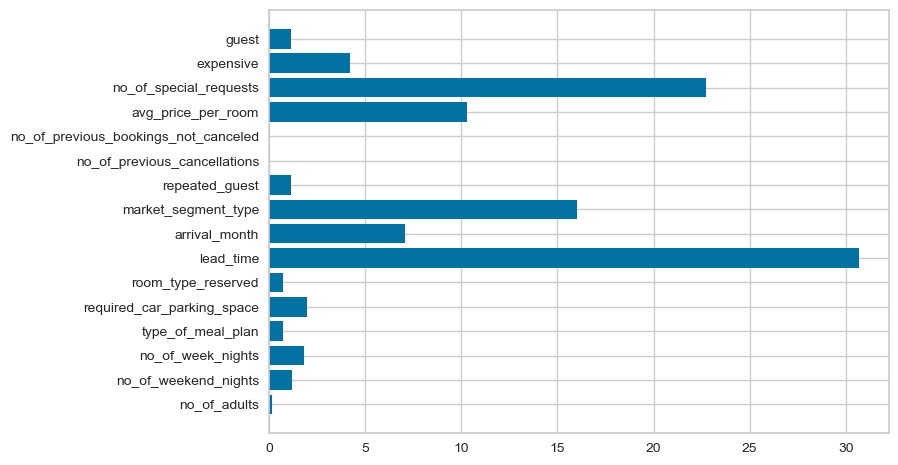

In [36]:
import matplotlib.pyplot as plt
plt.barh(cat.feature_names_,cat.feature_importances_)

<BarContainer object of 16 artists>

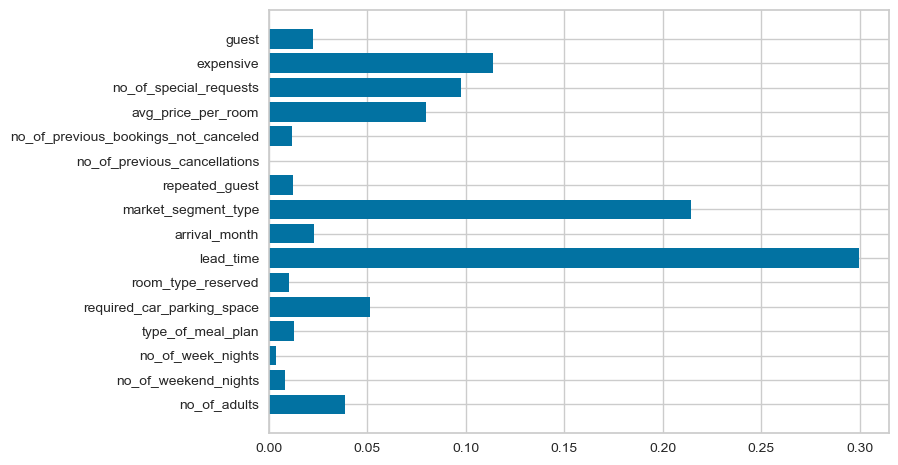

In [37]:
plt.barh(cat.feature_names_,xgb.feature_importances_)

<BarContainer object of 16 artists>

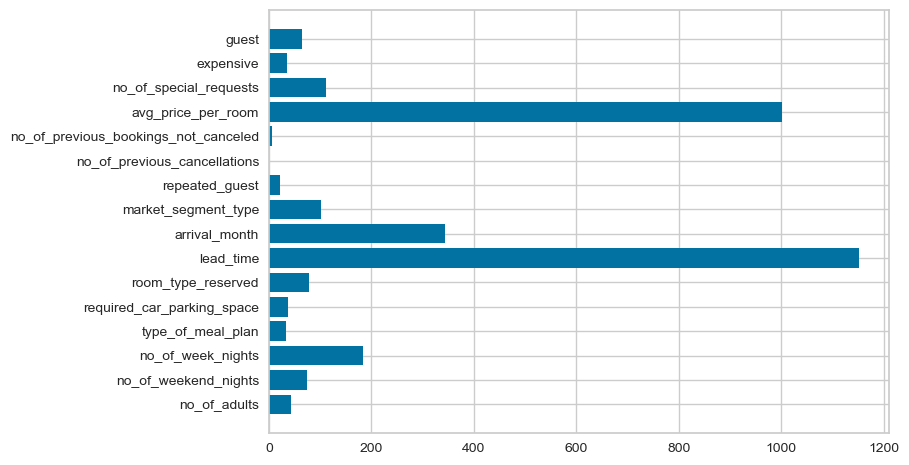

In [38]:
plt.barh(cat.feature_names_,lgb.feature_importances_)

<BarContainer object of 16 artists>

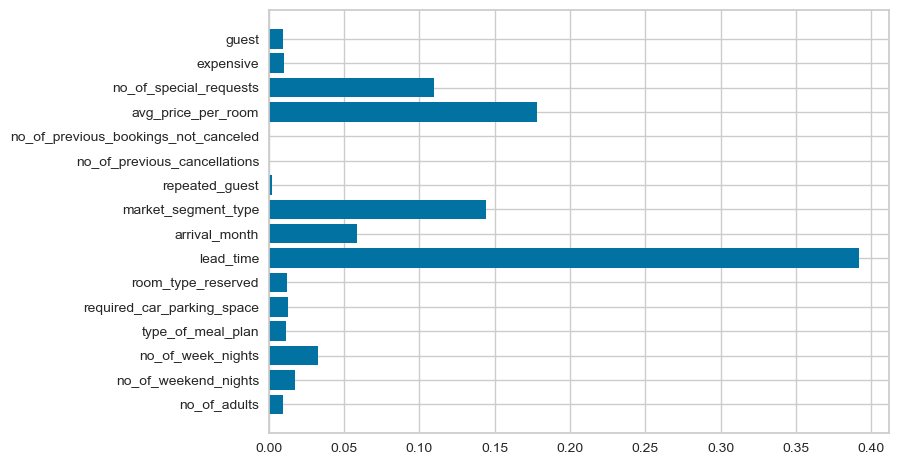

In [39]:
plt.barh(cat.feature_names_,gb.feature_importances_)

In [40]:
best_tune

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.001, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=3, missing=nan, monotone_constraints=None,
               n_estimators=140, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.2, max_depth=-1,
 

In [47]:
sub = pd.read_csv('./sample_submission.csv')
sub['booking_status'] = 0.3*np.array(proba[0]) + 0*np.array(proba[1]) + 0.5*np.array(proba[2]) + 0*np.array(proba[3])# np.array(proba).mean(axis=0)
sub = sub.set_index('id')
sub.to_csv('./submission.csv')

In [48]:
sub

,booking_status
id,
42100,0.446368
42101,0.161509
42102,0.756896
42103,0.097689
42104,0.625655
...,...
70163,1.887633
70164,0.084028
70165,0.169619


<AxesSubplot: ylabel='Frequency'>

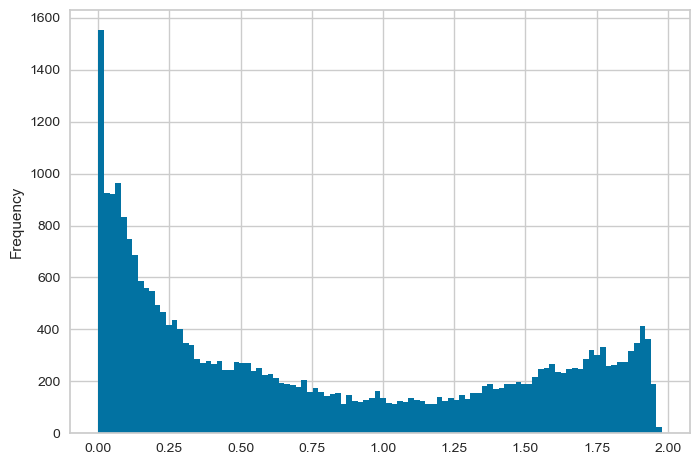

In [49]:
sub['booking_status'].plot.hist(bins=100)